# Fit KDE on docked poses

Notebook for fitting KDE on docked fragment poses.

Lets load the best docked poses

In [1]:
import pandas as pd

df_best_poses = pd.read_csv('mpro_frags_best_poses.csv')
df_best_poses

,RealCrystalName,smiles,score,ligand_index
0,Mpro-x0540,O=C(NCCC=1C=CN=CC1)NC2CCCCC2,58.0547,0
1,Mpro-x0426,FC=1C=CC=CC1C(=O)NCCC=2C=CN=CC2,57.3072,0
2,Mpro-x1093,CN1CCN(CC1)C(=O)CC1=CNC2=NC=CC=C12,52.5756,0
3,Mpro-x0967,CC(=O)NC(Cc1ccc(cc1)O)C(=O)NCC#CBr,51.2811,0
4,Mpro-x0104,CC(=O)NCCC1=CNC=2C=CC(F)=CC12,50.3251,1
5,Mpro-x0354,CN1CCN(CC1)C(=O)COC=2C=CC(C)=CC2,48.1828,1
6,Mpro-x0072,CS(=O)(=O)NCCC=1C=CC=CC1,47.1679,1
7,Mpro-x1249,O=C(NCC=1C=CC(C#N)=CC1)N2CCOCC2,47.0372,0
8,Mpro-x2193,CS(=O)(=O)c1ccc(cc1)N1CCNCC1,45.9846,0
9,Mpro-x1077,N#CC=1C=CC(=CN1)N2CCCOCC2,44.3030,0


Generate rdkit mol object by template matching onto conformer

In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdmolfiles import MolFromMol2File

n_poses = 5

mol_list = []
for index, row in df_best_poses.iterrows():
    
    for pose in range(1, n_poses+1):
        docked_mol_file = f"results/ranked_prepared_{row['RealCrystalName']}_m1_{pose}.mol2"

        docked_mol = MolFromMol2File(docked_mol_file)
        mol_from_smiles = Chem.MolFromSmiles(row['smiles'])

        ref_mol = AllChem.AssignBondOrdersFromTemplate(mol_from_smiles, docked_mol)
        df_best_poses.loc[index, f'mol_{pose}'] = ref_mol
        mol_list.append(ref_mol)

Generate pharmacophore dataframe

In [8]:
import numpy as np
from fresco.featurise import return_pcore_dataframe_for_list_of_mols

fragpcore_df = return_pcore_dataframe_for_list_of_mols(mol_list)
fragpcore_df

100%|██████████| 100/100 [00:00<00:00, 117.69it/s]


,pcore,smiles,mol_id,coord_x,coord_y,coord_z,weight
0,Donor,O=C(NCCc1ccncc1)NC1CCCCC1,0,-10.05240,12.918100,68.98190,0.2
0,Donor,O=C(NCCc1ccncc1)NC1CCCCC1,0,-11.18690,14.464400,70.59110,0.2
0,Acceptor,O=C(NCCc1ccncc1)NC1CCCCC1,0,-11.64940,14.429300,68.35640,0.2
0,Acceptor,O=C(NCCc1ccncc1)NC1CCCCC1,0,-12.30760,12.988600,63.43990,0.2
0,Aromatic,O=C(NCCc1ccncc1)NC1CCCCC1,0,-11.89415,12.534783,64.61515,0.2
...,...,...,...,...,...,...,...
0,Donor,CCC(=N)N,97,-13.13940,15.168500,70.35730,0.2
0,Donor,CCC(=N)N,98,-13.61550,15.293400,70.77210,0.2
0,Donor,CCC(=N)N,98,-14.41470,13.550200,72.11430,0.2
0,Donor,CCC(=N)N,99,-13.36360,15.105100,70.68100,0.2


In [9]:
from fresco.featurise import return_default_pharmacophore_pairs, calculate_pairwise_distances_between_pharmacophores_for_fragment_ensemble

pcore_pairs = return_default_pharmacophore_pairs()

frag_pair_distance_dict = {}   

for pcore_pair in pcore_pairs:
    core_a,core_b = pcore_pair.split('-')
    frag_pair_distance_dict[pcore_pair] = calculate_pairwise_distances_between_pharmacophores_for_fragment_ensemble(fragpcore_df, core_a, core_b)

frag_pair_distance_dict

{'Donor-Aromatic': array([4.9811157 , 4.57543579, 4.15421861, ..., 2.42432007, 2.73131736,
        2.62443094]),
 'Aromatic-Acceptor': array([7.2453126 , 5.21358261, 1.2337893 , ..., 5.45234707, 5.26137691,
        5.14599557]),
 'Aromatic-Aromatic': array([8.52103617, 0.37892421, 7.48734589, ..., 2.11662638, 1.87766149,
        1.34017946]),
 'Donor-Donor': array([1.18027388, 1.19100264, 1.90327487, ..., 3.87395064, 4.00442647,
        3.85961495]),
 'Donor-Acceptor': array([4.18694295, 3.21497396, 5.90938508, ..., 3.91608567, 1.63672244,
        3.84804738]),
 'Acceptor-Acceptor': array([4.01389917, 1.22962805, 5.39264649, ..., 5.42256939, 4.24048848,
        4.65643539])}

In [10]:

from fresco.model import fit_pair_kde

pair_kdes = {}

for pcore_pair in tqdm(pcore_pairs):
    core_a,core_b = pcore_pair.split('-')

    pair_data = frag_pair_distance_dict[pcore_pair]
    kde = fit_pair_kde(pair_data)
    pair_kdes[pcore_pair] = kde
    
pair_kdes

100%|██████████| 6/6 [00:00<00:00, 44.66it/s]


{'Donor-Aromatic': <scipy.interpolate.interpolate.interp1d at 0x7faa726e3a10>,
 'Aromatic-Acceptor': <scipy.interpolate.interpolate.interp1d at 0x7faa726e3530>,
 'Aromatic-Aromatic': <scipy.interpolate.interpolate.interp1d at 0x7faa726e30b0>,
 'Donor-Donor': <scipy.interpolate.interpolate.interp1d at 0x7faa726e3dd0>,
 'Donor-Acceptor': <scipy.interpolate.interpolate.interp1d at 0x7faa726e39b0>,
 'Acceptor-Acceptor': <scipy.interpolate.interpolate.interp1d at 0x7faa726e3470>}

/Users/williammccorkindale/miniconda3/envs/csd_env/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/williammccorkindale/miniconda3/envs/csd_env/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/williammccorkindale/miniconda3/envs/csd_env/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/williammccorkindale/miniconda3/envs/csd_env/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/williammc

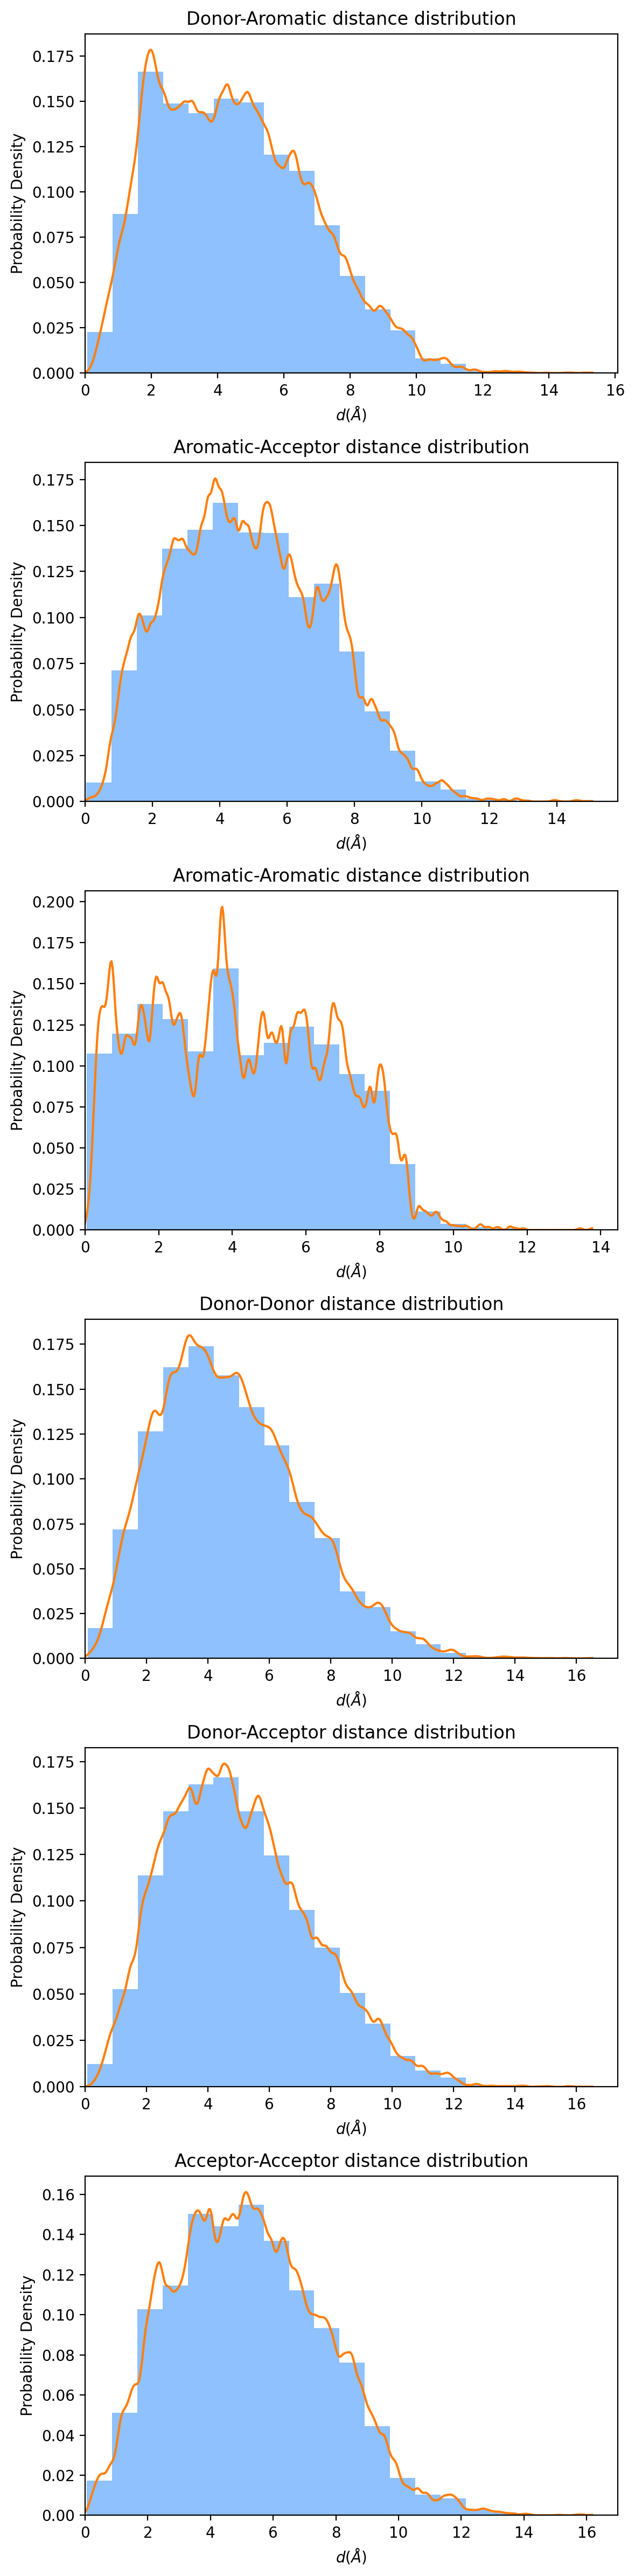

In [11]:
# import seaborn as sns
import matplotlib.pyplot as plt

nx = 500

n_bins = 20

cmap = plt.get_cmap("tab10")
# sns.set_style('white')

fig, axs = plt.subplots(nrows=6, figsize=(6, 24), dpi=200)
for i,combo in enumerate(pcore_pairs):
    x = np.linspace(0, np.amax(frag_pair_distance_dict[combo]), nx)
    kde_pair = pair_kdes[combo]
    axs[i].set_title('{} distance distribution'.format(
    combo))
    axs[i].hist(frag_pair_distance_dict[combo], bins=n_bins,
                alpha=0.5, density=True, color='#1E85FC')
    axs[i].plot(x, np.exp(kde_pair(x)), color=cmap(1))
    axs[i].set_xlim(left=0)
    axs[i].set_ylabel('Probability Density')
    axs[i].set_xlabel(r'$d (\AA)$')
    fig.tight_layout()
    fig.show()


In [12]:
from fresco.model import save_kde_model

# save_kde_model(filename='kde_on_docked_mpro_frags.pkl', kde_model=pair_kdes)
save_kde_model(filename=f'kde_on_{n_poses}_docked_mpro_frags.pkl', kde_model=pair_kdes)
